# Demo with CIFAR10 test data and histogram extraction
In this notebook, we are going to extract the histograms of images. Then, we average and plot them in order to see the distribution of colors in the full data. We do this only with the test data, since it is smaller and the notebook will execute faster, but you can easily do the same with the training data.

# Prerequisites

In [1]:
import numpy as np
from pathlib import Path

import torch
from torchvision.transforms import Compose
from torchvision.datasets import CIFAR10

from hyperpyper.transforms import (FileToPIL, PILtoHist)

from hyperpyper.aggregator import DataAggregator

from hyperpyper.utils import VisionDatasetDumper
from hyperpyper.utils import FolderScanner as fs

import matplotlib.pyplot as plt

random_state = 23

In [2]:
ROOT_PATH = Path.home() / "Downloads" / "data"

DATA_PATH = ROOT_PATH / "CIFAR10"

DATA_PATH_TEST = Path(DATA_PATH, "test")

## Function to plot the precomputed histograms

In [3]:
def plot_histograms(histograms):
    n_cols = len(histograms)

    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(4*len(histograms), 4))

    if n_cols==1:
        axes = np.array([axes])

    for h,ax in zip(histograms, axes):
        ax.bar(x=range(len(h)), height=h)

    return fig

## Create CIFAR10 test dataset organized in subfolders indicating the corresponding class label
The VisionDatasetDumper handles the download and the creation of a folder structure where images are stored. They can then be used as the starting point for experiments.

In [4]:
test_dataset = VisionDatasetDumper(CIFAR10, root=DATA_PATH, dst=DATA_PATH_TEST, train=False).dump()

Files already downloaded and verified


### Retrieve a list of .png files

In [5]:
test_files = fs.get_files(DATA_PATH_TEST, extensions='.png', recursive=True)
len(test_files)

10000

## Define Transformation pipeline
Notice, that we have a FileToPIL Transformation that handles the loading of the image. This enables us to use the standard Aggregator, where we don't need to take care of a DataSet or DataLoader instantiation.
All we need to pass as arguments is a file list and the transformation pipeline, and optionally a batch size.

In [6]:
transform_pipeline = Compose([
    FileToPIL(),
    PILtoHist(bins=64),
])

In [7]:
agg = DataAggregator(test_files, transforms=transform_pipeline, batch_size=1000)

test_hist_result, test_hist_files = agg.transform()

## Average the histograms and plot
Notice that the Aggregator yields the full batch with respect to each data point. We cannot simply add a transform in the pipeline that operates on the full batch, hence we must take the average after aggregating the full batch to end up with histograms of the full batch.

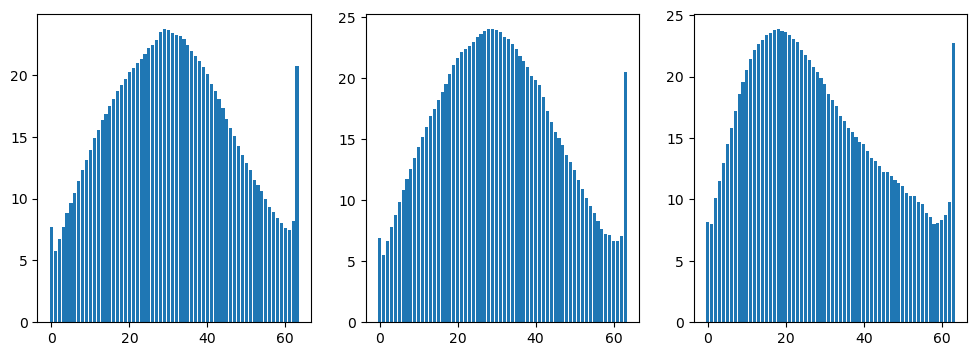

In [8]:
test_hist_avg = torch.mean(test_hist_result.float(), dim=0)

fig = plot_histograms(test_hist_avg)

## Another pipeline to process grayscale images
Simply using ```mode='L'``` as argument for image loading turns the image into a grayscale version, and the remaining components of the pipeline act accordingly, leading to just a single histogram instead of three.

In [9]:
transform_pipeline = Compose([
    FileToPIL(mode='L'),
    PILtoHist(bins=64),
])

In [10]:
agg = DataAggregator(test_files, transforms=transform_pipeline, batch_size=1000)

test_hist_result, test_hist_files = agg.transform()

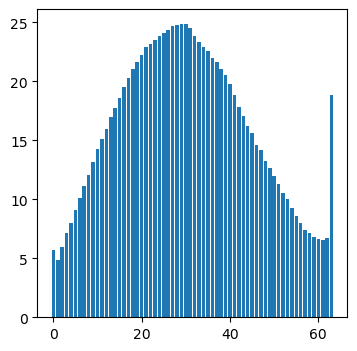

In [11]:
test_hist_avg = torch.mean(test_hist_result.float(), dim=0)

fig = plot_histograms(test_hist_avg)